# N-Asset Efficient Frontier

In [25]:
%load_ext autoreload
%autoreload 2 
from sys import path 
path.append('../')
import edhec_risk_kit as erk 
import pandas as pd

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


```python
def plot_ef(n_points, er, cov, style):
    """
    Plots the n-asset efficient frontier
    """
    # weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    # weights = ?????????? ==>> this is the problem we are solving
    # weights = minimize_vol(target_return)  ==>> this is what we have to do
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=style)
```

In [15]:
from scipy.optimize import minimize

<Axes: xlabel='Volatility'>

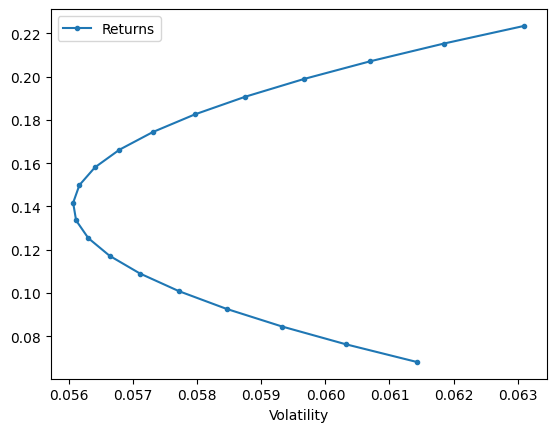

In [16]:
l = ['Games', 'Fin']
erk.plot_ef2(20, er[l], cov.loc[l,l])

In [17]:
import numpy as np

# def target_is_met(w, er, target_return):
#     """
#     Have to figure out if expected return match actual return 
#     """

#     return target_return -  erk.portfolio_return(w, er) == 0

def minimize_vol(target_return, er, cov):
    """
    go from target_return to a weight vector
    """

    n = er.shape[0]  # number of assets
    init_guess = np.repeat(1 / n, n)  # equal weight for all assets
    bounds = ((0.0, 1.0),) * n  # bounds = 0 to 100% - multiple bounds for each asset

    ## constraints ##
    return_is_target = {
        'type': 'eq',  # equality type constraint
        'args': (er,),
        'fun': lambda weights, er: target_return - erk.portfolio_return(weights, er) # satisfies constraint if function equals 0 (see target_is_met above - longer form of this)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }

    weights = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',  # quadratic optimizer
                       options={'disp': False},  # make it less verbose
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds)
    
    return weights.x

                       
      





In [18]:
l

['Games', 'Fin']

In [21]:
w15 = erk.minimize_vol(.15, er[l], cov.loc[l,l])  # find portfolio with target return of 15% and get the weights
vol15 = erk.portfolio_vol(w15, cov.loc[l,l])
vol15

0.056163669406706564

In [32]:
def optimal_weights(n_points, er, cov):
    """
    -> list of weights to run the optimizer on
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)  # n_points between min and max
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

     

def plot_ef(n_points, er, cov, style='-.'):
    """
    Plots the n-asset efficient frontier
    """
    # weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    # weights = ?????????? ==>> this is the problem we are solving
    # weights = minimize_vol(target_return)  ==>> this is what we have to do
    weights = optimal_weights(n_points, er, cov)
    rets = [erk.portfolio_return(w, er) for w in weights]
    vols = [erk.portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=style)

<Axes: xlabel='Volatility'>

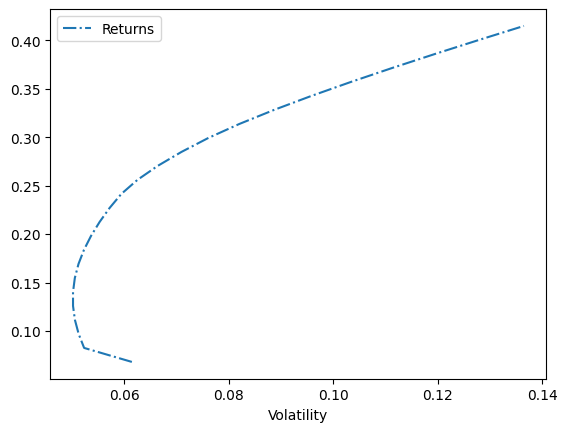

In [33]:
l = ['Smoke', 'Fin', 'Games', 'Coal']
plot_ef(25, er[l], cov.loc[l,l])

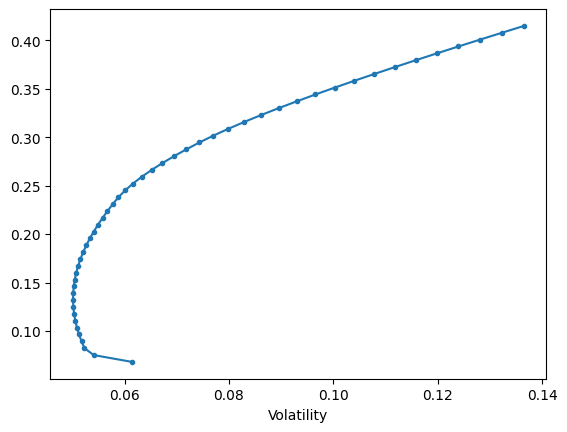

In [36]:
erk.plot_ef(50, er[l], cov.loc[l,l])